## Import Libraries

In [1]:
import timeit
from timeit import default_timer as timer
import math
import pandas as pd
import scipy.stats
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
start_time = timer()

## Read Dataset

In [2]:
data = pd.read_csv('card transactions.csv',parse_dates=['Date'])

In [3]:
data.columns

Index(['Recnum', 'Cardnum', 'Date', 'Merchnum', 'Merch description',
       'Merch state', 'Merch zip', 'Transtype', 'Amount', 'Fraud'],
      dtype='object')

In [4]:
data.shape

(96753, 10)

In [5]:
data.dtypes

Recnum                        int64
Cardnum                       int64
Date                 datetime64[ns]
Merchnum                     object
Merch description            object
Merch state                  object
Merch zip                   float64
Transtype                    object
Amount                      float64
Fraud                         int64
dtype: object

## Data Cleaning

In [6]:
data['Cardnum']=data['Cardnum'].astype('str')
data['Merchnum']=np.where((data['Merchnum']=='NaN') | (data['Merchnum']=='0'),np.nan,data['Merchnum'])
data['Merch zip']=data['Merch zip'].fillna(0).apply(lambda x:int(x))
data['Merch zip']=data['Merch zip'].apply(lambda x:str(x))
data['Merch zip']=np.where(data['Merch zip']=='0',np.nan,data['Merch zip'])
data=data.loc[data['Transtype']=='P',]
data=data.loc[data['Amount']<100000,]
data['Merch state'].fillna('Unknown',inplace=True)
data['Merch zip'].fillna('Unknown',inplace=True)
data['Merchnum'].fillna('Unknown',inplace=True)

In [7]:
data[data['Merch description'].notnull()]['Merch description']

0         FEDEX SHP 12/23/09 AB#
1        SERVICE MERCHANDISE #81
2              OFFICE DEPOT #191
3         FEDEX SHP 12/28/09 AB#
4         FEDEX SHP 12/23/09 AB#
                  ...           
96748     BEST BUY      00001610
96749     MARKUS OFFICE SUPPLIES
96750              TECH PAC, INC
96751                    BUY.COM
96752      STAPLES NATIONAL #471
Name: Merch description, Length: 96397, dtype: object

## Fill in Merchnum

In [8]:
merchdes_merchnum = {}
for index, merchdes in data[data['Merch description'].notnull()]['Merch description'].items():
    if merchdes not in merchdes_merchnum :
        merchdes_merchnum[merchdes] = data.loc[index, 'Merchnum']

# fill in by mapping with Merch description
data['Merchnum'] = data['Merchnum'].fillna(data['Merch description'].map(merchdes_merchnum))

# assign unknown for adjustments transactions
data['Merchnum'] = data['Merchnum'].mask(data['Merch description'] == 'RETAIL CREDIT ADJUSTMENT', 'unknown')
data['Merchnum'] = data['Merchnum'].mask(data['Merch description'] == 'RETAIL DEBIT ADJUSTMENT', 'unknown')

In [9]:
merchdes_merchnum

{'FEDEX SHP 12/23/09 AB#': '5509006296254',
 'SERVICE MERCHANDISE #81': '61003026333',
 'OFFICE DEPOT #191': '4503082993600',
 'FEDEX SHP 12/28/09 AB#': '5509006296254',
 'FEDEX SHP 12/22/09 AB#': '5509006296254',
 'MIAMI COMPUTER SUPPLY': '6098208200062',
 'FISHER SCI ATL': '602608969534',
 'FEDEX SHP 12/21/09 AB#': '5509006296254',
 'CDW*GOVERNMENT INC': '5725000466504',
 'FISHER SCI HUS': '602608969284',
 'AMAZON.COM  *SUPERSTRE': '4353000719908',
 'FEDEX SHP 12/14/09 AB#': '5509006296254',
 'DIRKS PLUMBING/HEATING REPAIRS': '4503738417400',
 'COM*COMARK GVT ED SALE': '7234000681204',
 'FISHER SCI DAL': '602608969739',
 'PTK*PUBLISH PERFECTION': '3443000643641',
 'FEDEX SHP 12/27/09 AB#': '5509006296254',
 'MWI*DATA COM': '9765000409955',
 'FISHER SCI CHI': '602608969138',
 'FERGUSON ENTERPRISES I': '602608038586',
 'IBM INTERNET  01000025': '5000006000095',
 'HEWLETT PACKARD CO': '9050153',
 'MTT*SKYTEL': '3397000747409',
 'RADIO SHACK   00187278': '4800000627972',
 'SOCIETY OF TOX

## Fill in Merch state

In [10]:
zip_state = {}
for index, zip5 in data[data['Merch zip'].notnull()]['Merch zip'].items():
    if zip5 not in zip_state:
        zip_state[zip5] = data.loc[index, 'Merch state']
        
zip_state['00926'] = 'PR'
zip_state['00929'] = 'PR'
zip_state['00934'] = 'PR'
zip_state['00902'] = 'PR'
zip_state['00738'] = 'PR'
zip_state['90805'] = 'CA'
zip_state['76302'] = 'TX'
zip_state['00914'] = 'PR'
zip_state['95461'] = 'CA'
zip_state['00680'] = 'PR'
zip_state['00623'] = 'PR'
zip_state['00726'] = 'PR'
zip_state['00936'] = 'PR'
zip_state['12108'] = 'NY'
zip_state['00791'] = 'PR'
zip_state['00907'] = 'PR'
zip_state['00922'] = 'PR'
zip_state['00920'] = 'PR'
zip_state['00801'] = 'VI'
zip_state['31040'] = 'GA'
zip_state['41160'] = 'KY'
zip_state['00681'] = 'PR'

merchnum_state = {}
for index, merchnum in data[data['Merchnum'].notnull()]['Merchnum'].items():
    if merchnum not in merchnum_state :
        merchnum_state [merchnum] = data.loc[index, 'Merch state']

merchdes_state = {}
for index, merchdes in data[data['Merch description'].notnull()]['Merch description'].items():
    if merchdes not in merchdes_state :
        merchdes_state [merchdes] = data.loc[index, 'Merch state']

In [11]:
# fill in by mapping with zip, merchnum and merch description
data['Merch state'] = data['Merch state'].fillna(data['Merch zip'].map(zip_state))
data['Merch state'] = data['Merch state'].fillna(data['Merchnum'].map(merchnum_state))
data['Merch state'] = data['Merch state'].fillna(data['Merch description'].map(merchdes_state))

# assign unknown for adjustments transactions
data['Merch state'] = data['Merch state'].mask(data['Merch description'] == 'RETAIL CREDIT ADJUSTMENT', 'unknown')
data['Merch state'] = data['Merch state'].mask(data['Merch description'] == 'RETAIL DEBIT ADJUSTMENT', 'unknown')

## MerchZip

In [12]:
merchnum_zip = {}
for index, merchnum in data[data['Merchnum'].notnull()]['Merchnum'].items():
    if merchnum not in merchnum_zip :
        merchnum_zip [merchnum] = data.loc[index, 'Merch zip']

merchdes_zip = {}
for index, merchdes in data[data['Merch description'].notnull()]['Merch description'].items():
    if merchdes not in merchdes_zip :
        merchdes_zip [merchdes] = data.loc[index, 'Merch zip']

# fill in by mapping with merchnum and merch description
data['Merch zip'] = data['Merch zip'].fillna(data['Merchnum'].map(merchnum_zip))
data['Merch zip'] = data['Merch zip'].fillna(data['Merch description'].map(merchdes_zip))

# assign unknown for adjustments transactions
data['Merch zip'] = data['Merch zip'].mask(data['Merch zip'] == 'RETAIL CREDIT ADJUSTMENT', 'unknown')
data['Merch zip'] = data['Merch zip'].mask(data['Merch zip'] == 'RETAIL DEBIT ADJUSTMENT', 'unknown')

# fill the rest with unknown
data = data.fillna('unknown')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96397 entries, 0 to 96752
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Recnum             96397 non-null  int64         
 1   Cardnum            96397 non-null  object        
 2   Date               96397 non-null  datetime64[ns]
 3   Merchnum           96397 non-null  object        
 4   Merch description  96397 non-null  object        
 5   Merch state        96397 non-null  object        
 6   Merch zip          96397 non-null  object        
 7   Transtype          96397 non-null  object        
 8   Amount             96397 non-null  float64       
 9   Fraud              96397 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(6)
memory usage: 10.1+ MB


## DAY OF WEEK TARGET ENCODING

In [13]:
data['DOW']=data['Date'].dt.strftime("%A")

In [14]:
data['DOW'].dtypes

dtype('O')

In [15]:
data['DOW'].head()

0    Sunday
1    Sunday
2    Sunday
3    Sunday
4    Sunday
Name: DOW, dtype: object

In [16]:
train_test = data[data.Date < '11/1/2006']

In [17]:
train_test.shape

(83970, 11)

In [18]:
c = 4; nmid = 20; y_avg = train_test['Fraud'].mean()
y_dow = train_test.groupby('DOW')['Fraud'].mean()
num = train_test.groupby('DOW').size()
y_dow_smooth = y_avg + (y_dow - y_avg)/(1 + np.exp(-(num-nmid)/c))
data['DOW_Risk'] = data.DOW.map(y_dow_smooth)

In [19]:
y_avg #the average of all the fraud labels

0.010479933309515303

In [20]:
y_dow

DOW
Friday       0.009788
Monday       0.010095
Saturday     0.018626
Sunday       0.025994
Thursday     0.007127
Tuesday      0.009630
Wednesday    0.008711
Name: Fraud, dtype: float64

In [21]:
y_dow = y_dow.reset_index()

In [22]:
y_dow

,DOW,Fraud
0,Friday,0.009788
1,Monday,0.010095
2,Saturday,0.018626
3,Sunday,0.025994
4,Thursday,0.007127
5,Tuesday,0.009630
6,Wednesday,0.008711


In [23]:
cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
y_dow['DOW'] = pd.Categorical(y_dow['DOW'], categories = cats, ordered = True)
y_dow = y_dow.sort_values('DOW')
y_dow = y_dow.set_index('DOW')

In [24]:
y_dow

,Fraud
DOW,
Monday,0.010095
Tuesday,0.009630
Wednesday,0.008711
Thursday,0.007127
Friday,0.009788
Saturday,0.018626
Sunday,0.025994


In [25]:
y_dow.index

CategoricalIndex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday',
                  'Saturday', 'Sunday'],
                 categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered=True, dtype='category', name='DOW')

Text(Sunday, 0.0265, '0.02599')

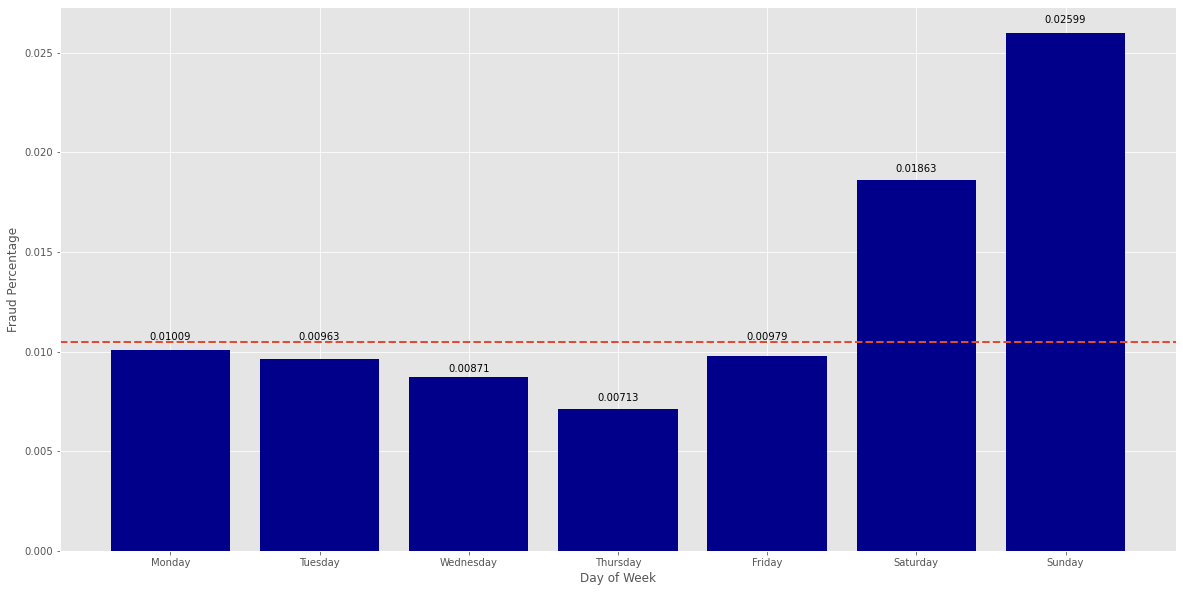

In [26]:
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize = (20,10))
plt.bar(data = y_dow, x=y_dow.index, height = 'Fraud', color = 'darkblue')
plt.xlabel('Day of Week')
plt.ylabel('Fraud Percentage')
#ax.set_ylim(bottom = 0.013)
ax.axhline(y = y_avg, ls = '--', lw = 2)
ax.text(y_dow.index[0], y_avg+ 0.0001, round(y_dow.Fraud[0],5) , ha='center')
ax.text(y_dow.index[1], y_avg + 0.0001, round(y_dow.Fraud[1],5) , ha='center')
ax.text(y_dow.index[2], 0.009, round(y_dow.Fraud[2],5) , ha='center')
ax.text(y_dow.index[3], 0.0075, round(y_dow.Fraud[3],5) , ha='center')
ax.text(y_dow.index[4], y_avg + 0.0001, round(y_dow.Fraud[4],5) , ha='center')
ax.text(y_dow.index[5], 0.019, round(y_dow.Fraud[5],5) , ha='center')
ax.text(y_dow.index[6], 0.0265, round(y_dow.Fraud[6],5) ,ha='center')

## MERCHANT STATE TARGET ENCODING

In [27]:
#c = 4; nmid = 20; y_avg = train_test['Fraud'].mean()
y_ms = train_test.groupby('Merch state')['Fraud'].mean()
num1 = train_test.groupby('Merch state').size()
y_ms_smooth = y_avg + (y_ms - y_avg)/(1 + np.exp(-(num1-nmid)/c))
data['MS_Risk'] = data['Merch state'].map(y_ms_smooth)

In [28]:
y_ms

Merch state
AB         0.000000
AK         0.000000
AL         0.006873
AR         0.000000
AZ         0.003185
             ...   
WA         0.020518
WI         0.001193
WV         0.000000
WY         0.000000
unknown    0.000000
Name: Fraud, Length: 61, dtype: float64

In [29]:
y_ms_smooth

Merch state
AB         1.029144e-02
AK         3.608225e-16
AL         6.872852e-03
AR         3.911833e-04
AZ         3.184713e-03
               ...     
WA         2.051836e-02
WI         1.193317e-03
WV         1.700029e-16
WY         2.818488e-03
unknown    0.000000e+00
Length: 61, dtype: float64

In [30]:
num1

Merch state
AB            4
AK          144
AL          291
AR           33
AZ          314
           ... 
WA         2778
WI          838
WV          147
WY           24
unknown     557
Length: 61, dtype: int64

In [31]:
data.columns

Index(['Recnum', 'Cardnum', 'Date', 'Merchnum', 'Merch description',
       'Merch state', 'Merch zip', 'Transtype', 'Amount', 'Fraud', 'DOW',
       'DOW_Risk', 'MS_Risk'],
      dtype='object')

<AxesSubplot:xlabel='Merch state', ylabel='Top 15 States With Highest Proportion of Frauds'>

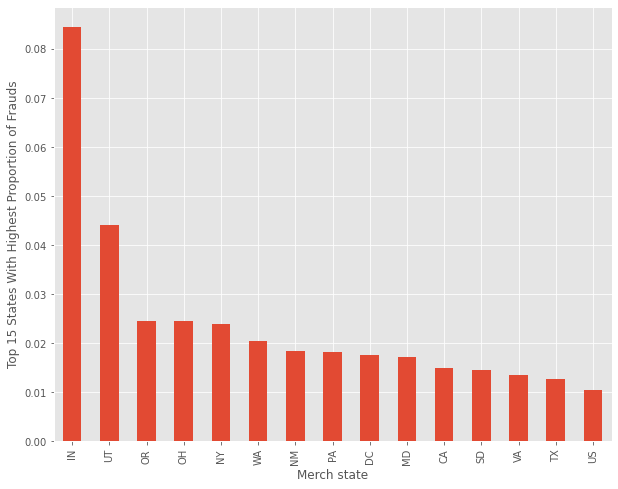

In [32]:
plt.figure(figsize=(10,8))
plt.xlabel('Merchant state')
plt.ylabel('Top 15 States With Highest Proportion of Frauds')
data.groupby(['Merch state'])['MS_Risk'].first().sort_values(ascending=False).head(15).plot(kind='bar')

## Build Candidate Variables

In [33]:
data['Cardnum_Merchnum'] = data.Cardnum + data.Merchnum
data['Cardnum_MerchState'] = data.Cardnum + data['Merch state']
data['Cardnum_MerchZip'] = data.Cardnum + data['Merch zip']
data['Cardnum_MerchDescription'] = data.Cardnum + data['Merch description']
data['Merchnum_Merchzip'] = data.Merchnum + data['Merch zip']
data['Merchnum_MerchState'] = data.Merchnum + data['Merch state']
data['Cardnum_Merchnum_MerchState'] = data.Cardnum + data.Merchnum + data['Merch state']
data['Cardnum_Merchnum_MerchZip'] = data.Cardnum + data.Merchnum + data['Merch zip']
#data['Merchnum_MerchDescription'] = data.Merchnum + data['Merch description']
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96397 entries, 0 to 96752
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Recnum                       96397 non-null  int64         
 1   Cardnum                      96397 non-null  object        
 2   Date                         96397 non-null  datetime64[ns]
 3   Merchnum                     96397 non-null  object        
 4   Merch description            96397 non-null  object        
 5   Merch state                  96397 non-null  object        
 6   Merch zip                    96397 non-null  object        
 7   Transtype                    96397 non-null  object        
 8   Amount                       96397 non-null  float64       
 9   Fraud                        96397 non-null  int64         
 10  DOW                          96397 non-null  object        
 11  DOW_Risk                     96397 non-nu

In [34]:
data['check_date'] = data.Date
data['check_record'] = data.Recnum
data['Date'] = pd.to_datetime(data['Date'],format='%Y-%m-%d')
data['check_date'] = pd.to_datetime(data['check_date'],format='%Y-%m-%d')
final = data.copy()
final.columns
#len(entities)

Index(['Recnum', 'Cardnum', 'Date', 'Merchnum', 'Merch description',
       'Merch state', 'Merch zip', 'Transtype', 'Amount', 'Fraud', 'DOW',
       'DOW_Risk', 'MS_Risk', 'Cardnum_Merchnum', 'Cardnum_MerchState',
       'Cardnum_MerchZip', 'Cardnum_MerchDescription', 'Merchnum_Merchzip',
       'Merchnum_MerchState', 'Cardnum_Merchnum_MerchState',
       'Cardnum_Merchnum_MerchZip', 'check_date', 'check_record'],
      dtype='object')

## Velocity/Count & Days Since

In [35]:
entities = ['Cardnum_Merchnum','Cardnum','Merchnum','Merch description','Cardnum_MerchState','Cardnum_MerchZip','Cardnum_MerchDescription', 'Merchnum_Merchzip', 'Merchnum_MerchState','Merch state','Merch zip','Cardnum_Merchnum_MerchState','Cardnum_Merchnum_MerchZip']

start = timeit.default_timer()
for entity in entities:    
    try: print('Run time for the last entity ----------------- {}s'.format(timeit.default_timer() - st))
    except: print('')
    st = timeit.default_timer()    
    ## Day-since variables:   
    df_l = data[['Recnum', 'Date', entity]]
    df_r = data[['check_record', 'check_date', entity, 'Amount']]    
    temp = pd.merge(df_l, df_r, left_on = entity, right_on = entity)   
    temp1 = temp[temp.Recnum > temp.check_record][['Recnum','Date','check_date']]\
                                                   .groupby('Recnum')[['Date', 'check_date']].last()
    mapper = (temp1.Date - temp1.check_date).dt.days
    final[entity + '_day_since'] = final.Recnum.map(mapper)
    final[entity + '_day_since'].fillna((final.Date - pd.to_datetime('2010-01-01')).dt.days, inplace = True)
    print('\n' + entity + '_day_since ---> Done')   
    ## Frequency & Amount variables:   
    for time in [0,1,3,7,14,30,60,90]:       
        temp2 = temp[(temp.check_date >= (temp.Date - dt.timedelta(time))) &\
                       (temp.Recnum >= temp.check_record)][['Recnum', entity, 'Amount']]       
        col_name = entity + '_count_' + str(time)    
        mapper2 = temp2.groupby('Recnum')[entity].count()      
        final[col_name] = final.Recnum.map(mapper2)        
        print(col_name + ' ---> Done')       
        final[entity + '_avg_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
        final[entity + '_max_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
        final[entity + '_med_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].median())
        final[entity + '_total_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].sum())
        final[entity + '_actual/avg_' + str(time)] = final['Amount'] / final[entity + '_avg_' + str(time)]
        final[entity + '_actual/max_' + str(time)] = final['Amount'] / final[entity + '_max_' + str(time)]
        final[entity + '_actual/med_' + str(time)] = final['Amount'] / final[entity + '_med_' + str(time)]
        final[entity + '_actual/toal_' + str(time)] = final['Amount'] / final[entity + '_total_' + str(time)]       
        print(entity + ' amount variables over past ' + str(time) + ' ---> Done')

print('Total run time: {}mins'.format((timeit.default_timer() - start)/60))




Cardnum_Merchnum_day_since ---> Done
Cardnum_Merchnum_count_0 ---> Done
Cardnum_Merchnum amount variables over past 0 ---> Done
Cardnum_Merchnum_count_1 ---> Done
Cardnum_Merchnum amount variables over past 1 ---> Done
Cardnum_Merchnum_count_3 ---> Done
Cardnum_Merchnum amount variables over past 3 ---> Done
Cardnum_Merchnum_count_7 ---> Done
Cardnum_Merchnum amount variables over past 7 ---> Done
Cardnum_Merchnum_count_14 ---> Done
Cardnum_Merchnum amount variables over past 14 ---> Done
Cardnum_Merchnum_count_30 ---> Done
Cardnum_Merchnum amount variables over past 30 ---> Done
Cardnum_Merchnum_count_60 ---> Done
Cardnum_Merchnum amount variables over past 60 ---> Done
Cardnum_Merchnum_count_90 ---> Done
Cardnum_Merchnum amount variables over past 90 ---> Done
Run time for the last entity ----------------- 2.561705s

Cardnum_day_since ---> Done
Cardnum_count_0 ---> Done
Cardnum amount variables over past 0 ---> Done
Cardnum_count_1 ---> Done
Cardnum amount variables over past 1 ---

C:\Users\karan\AppData\Local\Temp/ipykernel_19988/2492434921.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_total_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].sum())
C:\Users\karan\AppData\Local\Temp/ipykernel_19988/2492434921.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_actual/avg_' + str(time)] = final['Amount'] / final[entity + '_avg_' + str(time)]
C:\Users\karan\AppData\Local\Temp/ipykernel_19988/2492434921.py:31: PerformanceWarning: DataFrame is highly

Cardnum_count_7 ---> Done
Cardnum amount variables over past 7 ---> Done
Cardnum_count_14 ---> Done
Cardnum amount variables over past 14 ---> Done
Cardnum_count_30 ---> Done
Cardnum amount variables over past 30 ---> Done
Cardnum_count_60 ---> Done
Cardnum amount variables over past 60 ---> Done
Cardnum_count_90 ---> Done
Cardnum amount variables over past 90 ---> Done
Run time for the last entity ----------------- 8.048409499999998s


C:\Users\karan\AppData\Local\Temp/ipykernel_19988/2492434921.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_day_since'] = final.Recnum.map(mapper)



Merchnum_day_since ---> Done
Merchnum_count_0 ---> Done
Merchnum amount variables over past 0 ---> Done
Merchnum_count_1 ---> Done
Merchnum amount variables over past 1 ---> Done
Merchnum_count_3 ---> Done
Merchnum amount variables over past 3 ---> Done
Merchnum_count_7 ---> Done
Merchnum amount variables over past 7 ---> Done
Merchnum_count_14 ---> Done
Merchnum amount variables over past 14 ---> Done
Merchnum_count_30 ---> Done
Merchnum amount variables over past 30 ---> Done
Merchnum_count_60 ---> Done
Merchnum amount variables over past 60 ---> Done
Merchnum_count_90 ---> Done
Merchnum amount variables over past 90 ---> Done
Run time for the last entity ----------------- 49.0870994s

Merch description_day_since ---> Done
Merch description_count_0 ---> Done
Merch description amount variables over past 0 ---> Done
Merch description_count_1 ---> Done
Merch description amount variables over past 1 ---> Done
Merch description_count_3 ---> Done
Merch description amount variables over pa

Cardnum_Merchnum_MerchState_count_60 ---> Done
Cardnum_Merchnum_MerchState amount variables over past 60 ---> Done
Cardnum_Merchnum_MerchState_count_90 ---> Done
Cardnum_Merchnum_MerchState amount variables over past 90 ---> Done
Run time for the last entity ----------------- 4.374574400000029s

Cardnum_Merchnum_MerchZip_day_since ---> Done
Cardnum_Merchnum_MerchZip_count_0 ---> Done
Cardnum_Merchnum_MerchZip amount variables over past 0 ---> Done
Cardnum_Merchnum_MerchZip_count_1 ---> Done
Cardnum_Merchnum_MerchZip amount variables over past 1 ---> Done
Cardnum_Merchnum_MerchZip_count_3 ---> Done
Cardnum_Merchnum_MerchZip amount variables over past 3 ---> Done
Cardnum_Merchnum_MerchZip_count_7 ---> Done
Cardnum_Merchnum_MerchZip amount variables over past 7 ---> Done
Cardnum_Merchnum_MerchZip_count_14 ---> Done
Cardnum_Merchnum_MerchZip amount variables over past 14 ---> Done
Cardnum_Merchnum_MerchZip_count_30 ---> Done
Cardnum_Merchnum_MerchZip amount variables over past 30 ---> Done

## Relative Velocity

In [73]:
start = timeit.default_timer()
# velocity change variables
for ent in entities:
    for d in ['0', '1']:
        for dd in ['3','7', '14', '30','60','90']:
            final[ent + '_count_' + d + '_by_' + dd] =\
            final[ent + '_count_' + d]/(final[ent + '_count_' + dd])/float(dd)
            
print('run time: {}s'.format(timeit.default_timer() - start))

run time: 0.10767669999995633s


In [74]:
final.columns

Index(['Recnum', 'Cardnum', 'Date', 'Merchnum', 'Merch description',
       'Merch state', 'Merch zip', 'Transtype', 'Amount', 'Fraud',
       ...
       'Cardnum_Merchnum_MerchZip_count_0_by_14',
       'Cardnum_Merchnum_MerchZip_count_0_by_30',
       'Cardnum_Merchnum_MerchZip_count_0_by_60',
       'Cardnum_Merchnum_MerchZip_count_0_by_90',
       'Cardnum_Merchnum_MerchZip_count_1_by_3',
       'Cardnum_Merchnum_MerchZip_count_1_by_7',
       'Cardnum_Merchnum_MerchZip_count_1_by_14',
       'Cardnum_Merchnum_MerchZip_count_1_by_30',
       'Cardnum_Merchnum_MerchZip_count_1_by_60',
       'Cardnum_Merchnum_MerchZip_count_1_by_90'],
      dtype='object', length=1128)

## BENORD'S LAW VARIABLES

In [75]:
cleaned_data=final[final['Merch description'].str.match(r"[Ff][Ee][Dd][Ee][Xx]")==False].copy()
cleaned_data['Amount']=cleaned_data['Amount'].astype(str)

In [76]:
def n_low(df):
    return ((df['Amount'].str.extract(r"([1-9])")=='1')|(df['Amount'].str.extract(r"([1-9])")=='2')).sum() 

In [77]:
cardnums = cleaned_data.groupby('Cardnum').apply(n_low)
cardnums['n'] = cleaned_data.groupby('Cardnum')['Amount'].count()
cardnums['n_low' ]=cleaned_data.groupby('Cardnum').apply(n_low)
cardnums=cardnums[['n','n_low']]
cardnums["n_high"]= cardnums['n']-cardnums['n_low']



In [78]:
cardnums['n_low']=cardnums['n_low'].replace(0,1)
cardnums['n_high']=cardnums['n_high'].replace(0,1)

In [79]:
cardnums['R'] = 1.096 * cardnums['n_low'] / cardnums['n_high']
cardnums['1/R'] = 1 / cardnums['R']
cardnums['U'] = cardnums[['R', '1/R']].max(axis = 1)

In [80]:
cardnums['t']=(cardnums['n']-15) /3
cardnums['U*']= 1 + ( (cardnums['U' ]-1) / (1+math.e**-cardnums['t']))

In [81]:
cardnums.sort_values('U*',ascending=False)[0:40].to_csv('Top 40 Cardnum.csv')

In [82]:
merchnums=cleaned_data.groupby('Merchnum').apply(n_low)
merchnums['n']=cleaned_data.groupby('Merchnum')['Amount'].count()

In [83]:
merchnums['n_low']=cleaned_data.groupby('Merchnum').apply(n_low)
merchnums=merchnums[['n','n_low']]
merchnums["n_high"]= merchnums['n']-merchnums['n_low']

In [84]:
merchnums['n_low']=merchnums['n_low'].replace(0,1)
merchnums['n_high']=merchnums['n_high'].replace(0,1)

In [85]:
merchnums['R'] = 1.096 * merchnums['n_low'] / merchnums['n_high']
merchnums['1/R'] = 1 / merchnums['R']
merchnums['U'] = merchnums[['R', '1/R']].max(axis = 1)

In [86]:
merchnums['t']=(merchnums['n']-15) /3
merchnums['U*']= 1 + ( (merchnums['U' ]-1) / (1+math.e**-merchnums['t']))

In [87]:
merchnums.sort_values('U*',ascending=False)[0:40].to_csv('Top 40 Merchnum.csv')

In [88]:
cardnums

,n,n_low,n_high,R,1/R,U,t,U*
Cardnum,,,,,,,,
5142110002,1,1,1,1.096000,0.912409,1.096000,-4.666667,1.000894
5142110081,4,1,4,0.274000,3.649635,3.649635,-3.666667,1.066041
5142110313,3,2,1,2.192000,0.456204,2.192000,-4.000000,1.021440
5142110402,11,3,8,0.411000,2.433090,2.433090,-1.333333,1.298955
5142110434,1,1,1,1.096000,0.912409,1.096000,-4.666667,1.000894
...,...,...,...,...,...,...,...,...
5142310397,1,1,1,1.096000,0.912409,1.096000,-4.666667,1.000894
5142310525,4,1,3,0.365333,2.737226,2.737226,-3.666667,1.043299
5142310598,2,2,1,2.192000,0.456204,2.192000,-4.333333,1.015441


In [89]:
Cardnumber = cardnums.reset_index()

In [90]:
Cardnumber

,Cardnum,n,n_low,n_high,R,1/R,U,t,U*
0,5142110002,1,1,1,1.096000,0.912409,1.096000,-4.666667,1.000894
1,5142110081,4,1,4,0.274000,3.649635,3.649635,-3.666667,1.066041
2,5142110313,3,2,1,2.192000,0.456204,2.192000,-4.000000,1.021440
3,5142110402,11,3,8,0.411000,2.433090,2.433090,-1.333333,1.298955
4,5142110434,1,1,1,1.096000,0.912409,1.096000,-4.666667,1.000894
...,...,...,...,...,...,...,...,...,...
1635,5142310397,1,1,1,1.096000,0.912409,1.096000,-4.666667,1.000894
1636,5142310525,4,1,3,0.365333,2.737226,2.737226,-3.666667,1.043299
1637,5142310598,2,2,1,2.192000,0.456204,2.192000,-4.333333,1.015441
1638,5142310768,4,2,2,1.096000,0.912409,1.096000,-3.666667,1.002393


In [91]:
final.columns

Index(['Recnum', 'Cardnum', 'Date', 'Merchnum', 'Merch description',
       'Merch state', 'Merch zip', 'Transtype', 'Amount', 'Fraud',
       ...
       'Cardnum_Merchnum_MerchZip_count_0_by_14',
       'Cardnum_Merchnum_MerchZip_count_0_by_30',
       'Cardnum_Merchnum_MerchZip_count_0_by_60',
       'Cardnum_Merchnum_MerchZip_count_0_by_90',
       'Cardnum_Merchnum_MerchZip_count_1_by_3',
       'Cardnum_Merchnum_MerchZip_count_1_by_7',
       'Cardnum_Merchnum_MerchZip_count_1_by_14',
       'Cardnum_Merchnum_MerchZip_count_1_by_30',
       'Cardnum_Merchnum_MerchZip_count_1_by_60',
       'Cardnum_Merchnum_MerchZip_count_1_by_90'],
      dtype='object', length=1128)

In [92]:
final.shape

(96397, 1128)

In [93]:
temp1 = final.merge(Cardnumber, how= 'left', left_on=final.Cardnum,right_on = Cardnumber.Cardnum)

C:\Users\karan\anaconda3\lib\site-packages\pandas\core\reshape\merge.py:121: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  return op.get_result()


In [94]:
temp1.shape

(96397, 1138)

In [95]:
temp1.columns

Index(['key_0', 'Recnum', 'Cardnum_x', 'Date', 'Merchnum', 'Merch description',
       'Merch state', 'Merch zip', 'Transtype', 'Amount',
       ...
       'Cardnum_Merchnum_MerchZip_count_1_by_90', 'Cardnum_y', 'n', 'n_low',
       'n_high', 'R', '1/R', 'U', 't', 'U*'],
      dtype='object', length=1138)

In [96]:
temp1=temp1.drop(['key_0', 'Cardnum_y','n', 'n_low',
       'n_high', 'R', '1/R', 'U', 't'], axis=1)

In [97]:
temp1 = temp1.rename(columns={'U*': 'Cardnum_U*'})

In [98]:
temp1.columns

Index(['Recnum', 'Cardnum_x', 'Date', 'Merchnum', 'Merch description',
       'Merch state', 'Merch zip', 'Transtype', 'Amount', 'Fraud',
       ...
       'Cardnum_Merchnum_MerchZip_count_0_by_30',
       'Cardnum_Merchnum_MerchZip_count_0_by_60',
       'Cardnum_Merchnum_MerchZip_count_0_by_90',
       'Cardnum_Merchnum_MerchZip_count_1_by_3',
       'Cardnum_Merchnum_MerchZip_count_1_by_7',
       'Cardnum_Merchnum_MerchZip_count_1_by_14',
       'Cardnum_Merchnum_MerchZip_count_1_by_30',
       'Cardnum_Merchnum_MerchZip_count_1_by_60',
       'Cardnum_Merchnum_MerchZip_count_1_by_90', 'Cardnum_U*'],
      dtype='object', length=1129)

In [99]:
merchnums

,n,n_low,n_high,R,1/R,U,t,U*
Merchnum,,,,,,,,
003100006NOT6,1,1,1,1.096000,0.912409,1.096000,-4.666667,1.000894
004740006ABC6,1,1,1,1.096000,0.912409,1.096000,-4.666667,1.000894
005590006PNB6,1,1,1,1.096000,0.912409,1.096000,-4.666667,1.000894
014430619 14,1,1,1,1.096000,0.912409,1.096000,-4.666667,1.000894
014938913 51,1,1,1,1.096000,0.912409,1.096000,-4.666667,1.000894
...,...,...,...,...,...,...,...,...
JCPENNE9 CO,3,1,2,0.548000,1.824818,1.824818,-4.000000,1.014835
PENNE9 CO #05,1,1,1,1.096000,0.912409,1.096000,-4.666667,1.000894
PENNE9 CO #68,1,1,1,1.096000,0.912409,1.096000,-4.666667,1.000894


In [100]:
Merchnumber = merchnums.reset_index()

In [101]:
temp2 = temp1.merge(Merchnumber, how='left', left_on=final.Merchnum,right_on = Merchnumber.Merchnum)

C:\Users\karan\anaconda3\lib\site-packages\pandas\core\reshape\merge.py:121: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  return op.get_result()


In [102]:
temp2.shape

(96397, 1139)

In [103]:
final_df=temp2.drop(['key_0', 'Merchnum_y','n', 'n_low',
       'n_high', 'R', '1/R', 'U', 't'], axis=1)

In [104]:
final_df = final_df.rename(columns={'U*': 'Merchnum_U*'})

In [105]:
final_df.columns

Index(['Recnum', 'Cardnum_x', 'Date', 'Merchnum_x', 'Merch description',
       'Merch state', 'Merch zip', 'Transtype', 'Amount', 'Fraud',
       ...
       'Cardnum_Merchnum_MerchZip_count_0_by_60',
       'Cardnum_Merchnum_MerchZip_count_0_by_90',
       'Cardnum_Merchnum_MerchZip_count_1_by_3',
       'Cardnum_Merchnum_MerchZip_count_1_by_7',
       'Cardnum_Merchnum_MerchZip_count_1_by_14',
       'Cardnum_Merchnum_MerchZip_count_1_by_30',
       'Cardnum_Merchnum_MerchZip_count_1_by_60',
       'Cardnum_Merchnum_MerchZip_count_1_by_90', 'Cardnum_U*', 'Merchnum_U*'],
      dtype='object', length=1130)

In [106]:
final_df.to_csv('candidate_variables_new.csv')

In [70]:
final_list= list(final_df.columns)

In [71]:
final_data = pd.DataFrame(final_list)

In [72]:
final_data.to_csv('col_Names.csv')